#CycleGAN

Это домашнее задание действительно было одним из самых сложных. Пришлось копаться в туче статей, форумов, разбираться в архитектурах, новых лоссах. Ну как новых. Они, конечно, старые, но в ганах представились в новом свете.


Теперь к делу. Я долго ломал голову над интересной идеей для CycleGAN и мне пришла на ум идея менять время обычных фото\пейзажей на закат. Пришлось собирать руками датасет, на что я успешно потратил 2 дня, да еще и родственников пришлось подключать.

Вначале в качестве архитектуры генератора я использовал связку пары сверток, множества реснет блоков и пары обратных сверток. Изображение получалось очень нечетким и с большим количеством артефактов. Потом я выбрал UNet. Он работал намного лучше. Сгенерированная картинка была намного четче, и большинство артефактов исчезли.

Потом я прочитал об особой инициализации весов из нормального распределения. Уменьшил lr дискриминатора. Менял трансформы, архитектуру дискриминатора. 

Все это заняло приличное количество времени.
Результатом в целом я доволен: разобрался в GANах и их зоопарке, да еще и напилил не самую худшую сеть.

Удачные образцы находятся в папке gan_images

##imports

In [0]:
!wget -q https://www.dropbox.com/s/08nh4hupnuvw8kd/gan_images.zip
!mkdir gan_images
!unzip -qq gan_images.zip -d gan_images

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!wget https://www.dropbox.com/s/hsvdm7azjsaj9sc/landscapes_sh.zip -q
!wget https://www.dropbox.com/s/app3rwqbyqkdx58/sunsets.zip -q
!unzip -qq /content/landscapes_sh.zip 
!unzip -qq /content/sunsets.zip 

In [2]:
import os
len(os.listdir("/content/landscapes_sh"))

551

In [0]:
import os, pdb, pickle
import itertools
import random
import glob


import warnings
warnings.filterwarnings("ignore")

import numpy as np
import scipy 
import scipy.misc
import matplotlib.pyplot as plt
from IPython.display import clear_output
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.utils as vutils

##constants

In [0]:
X_path = '/content/landscapes_sh'
Y_path = '/content/sunsets'
BATCH_SIZE = 5
DF = 64 #discriminator features
IMAGE_SIZE = 256

##utils 

In [0]:
def count_params(model):
  return sum(i.numel() for i in model.parameters() if i.requires_grad)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

def save_model(G_x2y, G_y2x, Dx, Dy):
  DIR_WEIGHTS = "/content/drive/My Drive/weights"
  torch.save(G_x2y.state_dict(), DIR_WEIGHTS + "/G_x2y.wgt")
  torch.save(G_y2x.state_dict(), DIR_WEIGHTS + "/G_y2x.wgt")
  torch.save(Dx.state_dict(), DIR_WEIGHTS + "/Dx.wgt")
  torch.save(Dy.state_dict(), DIR_WEIGHTS + "/Dy.wgt")
  print("model saved")

def prepare_image(image):
    image = image.cpu().numpy().transpose((1,2,0))
    image = np.clip(image, 0, 1)
    return image

def show_image(image):
  image = prepare_image(image)
  fig, ax = plt.subplot(figsize=(6,6))
  plt.imshow(image)

def show_images(realx, fakex, recx, realy, fakey, recy):
  fig,ax = plt.subplots(nrows=2, ncols=3, figsize=(18,12), sharex=True, sharey=True)
  
  plt.subplot(2,3,1)
  plt.imshow(prepare_image(realx))
  plt.title("Real X")
  plt.axis("off")

  plt.subplot(2,3,2)
  plt.imshow(prepare_image(fakey))
  plt.title("Fake X")
  plt.axis("off")

  plt.subplot(2,3,3)
  plt.imshow(prepare_image(recx))
  plt.title("Recovered X")
  plt.axis("off")

  plt.subplot(2,3,4)
  plt.imshow(prepare_image(realy))
  plt.title("Real Y")
  plt.axis("off")

  plt.subplot(2,3,5)
  plt.imshow(prepare_image(fakex))
  plt.title("Fake Y")
  plt.axis("off")

  plt.subplot(2,3,6)
  plt.imshow(prepare_image(recy))
  plt.title("Recovered Y")
  plt.axis("off")


##data


In [0]:
class ImageDataset(Dataset):
    def __init__(self, xpath, ypath, transform=None, unaligned=False):
        super(ImageDataset).__init__()
        self.transform = transform
        self.unaligned = unaligned

        self.files_x = sorted(glob.glob(xpath + "/*.*"))
        self.files_y = sorted(glob.glob(ypath + "/*.*"))

    def __getitem__(self, index):
        x = self.transform(Image.open(self.files_x[index % len(self.files_x)]))

        if self.unaligned:
            y = self.transform(Image.open(self.files_y[random.randint(0, len(self.files_y) - 1)]))
        else:
            y = self.transform(Image.open(self.files_y[index % len(self.files_y)]))

        return {"X": x, "Y": y}

    def __len__(self):
        return len(self.files_x) + len(self.files_y)


img_transform = transforms.Compose([
                           transforms.Resize(int(IMAGE_SIZE * 1.12), Image.BICUBIC),
                           transforms.RandomCrop(IMAGE_SIZE),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = ImageDataset(xpath=X_path, ypath=Y_path,
                       transform=img_transform,
                       unaligned=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)#, pin_memory=True)

In [8]:
for batch in dataloader:
  print(batch['Y'].shape)
  break

torch.Size([5, 3, 256, 256])


##models

In [0]:
class GeneratorU(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.pool1 =  nn.MaxPool2d(kernel_size=2, stride=2)# 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
            )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv =  nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear') # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        self.upsample1 =  nn.Upsample(scale_factor=2, mode='bilinear')# 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            )
        self.upsample2 =  nn.Upsample(scale_factor=2, mode='bilinear') # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            )
        self.upsample3 =  nn.Upsample(scale_factor=2, mode='bilinear') # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=1)
            )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        #print(f"b shape:{b.shape}\ne3 shape: {e3.shape}")    
        d0 = self.dec_conv0(torch.cat((self.upsample0(b), e3),dim=1))
        d1 = self.dec_conv1(torch.cat((self.upsample1(d0), e2),dim=1))
        d2 = self.dec_conv2(torch.cat((self.upsample2(d1), e1),dim=1))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2),e0 ),dim=1))  # no activation
        return d3

class Discriminator(nn.Module):
  def __init__(self):
    '''  BS x channels x W x H ---> classificator BS x 1 x 1 x 1
    '''
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=DF, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
    
        nn.Conv2d(in_channels=DF, out_channels=DF*2, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(DF * 2),
        nn.LeakyReLU(0.2, inplace=True),
    
        nn.Conv2d(in_channels=DF * 2, out_channels=DF*4, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(DF * 4),
        nn.LeakyReLU(0.2, inplace=True),
    
        nn.Conv2d(in_channels=DF * 4, out_channels=DF*8, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(DF * 8),
        nn.LeakyReLU(0.2, inplace=True),
    
        nn.Conv2d(in_channels=DF*8, out_channels=1, kernel_size=2, stride=1, padding=0, bias=False)    )

  def forward(self, x):

    x = self.main(x)
    x = F.avg_pool2d(x, x.size()[2:])
    return x

##train

In [0]:
G_x2y = GeneratorU().cuda()
G_y2x = GeneratorU().cuda()
Dx = Discriminator().cuda()
Dy = Discriminator().cuda()

In [0]:
G_x2y.apply(weights_init)
G_y2x.apply(weights_init)
Dx.apply(weights_init)
Dy.apply(weights_init)

Ссылки на веса:

In [0]:
!wget -q
!wget -q
!wget -q
!wget -q

In [12]:
G_x2y.load_state_dict(torch.load("/content/drive/My Drive/weights/G_x2y.wgt"))
G_y2x.load_state_dict(torch.load("/content/drive/My Drive/weights/G_y2x.wgt"))
Dx.load_state_dict(torch.load("/content/drive/My Drive/weights/Dx.wgt"))
Dy.load_state_dict(torch.load("/content/drive/My Drive/weights/Dy.wgt"))

<All keys matched successfully>

In [0]:
EPOCHS = 100
LR = 0.0002
D_LR = 0.00001
SHOW_EPOCHS = 5
SAVE_EPOCHS = 3

cycle_loss = torch.nn.L1Loss().cuda()
identity_loss = torch.nn.L1Loss().cuda()
adv_loss = torch.nn.MSELoss().cuda()

g_opt = torch.optim.Adam(itertools.chain(G_x2y.parameters(), G_y2x.parameters()),
                         lr = LR, betas=(0.5, 0.999))
dx_opt = torch.optim.Adam(Dx.parameters(),lr=D_LR, betas=(0.5, 0.999))
dy_opt = torch.optim.Adam(Dy.parameters(),lr=D_LR, betas=(0.5, 0.999))

In [0]:
g_losses = []
d_losses = []
identity_losses = []
gan_losses = []
cycle_losses = []

In [0]:
for epoch in range(EPOCHS):
  if epoch % SAVE_EPOCHS == 0 and epoch != 0:
    save_model(G_x2y, G_y2x, Dx, Dy)
    
  progress_bar = tqdm(enumerate(dataloader), total=len(dataloader))
  for i, data in progress_bar:

    
    real_image_x = data["X"].cuda()
    real_image_y = data["Y"].cuda()
    batch_size = real_image_x.size(0)

    real_label = torch.ones(batch_size, 1,dtype=torch.float32).cuda()
    fake_label = torch.zeros(batch_size, 1,dtype=torch.float32).cuda()

    #Update Genetarors weights

    #Identity loss
    g_opt.zero_grad()

    identity_image_x = G_y2x(real_image_x)
    identity_loss_x = identity_loss(identity_image_x, real_image_x) * 5.0

    identity_image_y = G_x2y(real_image_y)
    identity_loss_y = identity_loss(identity_image_y, real_image_y) * 5.0

    #GAN loss
    ##y2x loss
    fake_image_x = G_y2x(real_image_y)
    fake_output_x = Dx(fake_image_x)
    GAN_loss_y2x = adv_loss(fake_output_x, real_label)
    
    ##x2y loss
    fake_image_y = G_x2y(real_image_x)
    fake_output_y = Dy(fake_image_y)
    GAN_loss_x2y = adv_loss(fake_output_y, real_label)


    #Cycle loss

    recovered_x = G_y2x(fake_image_y)
    cycle_loss_x2x = cycle_loss(recovered_x, real_image_x) * 10.0

    recovered_y = G_x2y(fake_image_x)
    cycle_loss_y2y = cycle_loss(recovered_y, real_image_y) * 10.0

    g_loss = identity_loss_y + identity_loss_x + GAN_loss_y2x + GAN_loss_x2y + cycle_loss_x2x + cycle_loss_y2y

    g_loss.backward()
    g_opt.step()


    #Update Discriminators weights
    ## x2y discriminator
    Dx.zero_grad()

    real_out_x = Dx(real_image_x)
    real_loss_dx = adv_loss(real_out_x, real_label)

    fake_out_x = Dx(fake_image_x.detach())
    fake_loss_dx = adv_loss(fake_out_x, fake_label)

    dx_loss = real_loss_dx + fake_loss_dx
    dx_loss.backward()
    dx_opt.step()


    ## y2x discriminator
    Dy.zero_grad()

    real_out_y = Dy(real_image_y)
    real_loss_dy = adv_loss(real_out_y, real_label)

    fake_out_y = Dy(fake_image_y.detach())
    fake_loss_dy = adv_loss(fake_out_y, fake_label)

    dy_loss = real_loss_dy + fake_loss_dy
    dy_loss.backward()
    dy_opt.step()


    progress_bar.set_description(
            f"[{epoch}/{EPOCHS - 1}][{i}/{len(dataloader) - 1}] "
            f"Loss_D: {(dy_loss + dx_loss).item():.4f} "
            f"Loss_G: {g_loss.item():.4f} "
            f"Loss_G_identity: {(identity_loss_x + identity_loss_y).item():.4f} "
            f"loss_G_GAN: {(GAN_loss_x2y + GAN_loss_y2x).item():.4f} "
            f"loss_G_cycle: {(cycle_loss_x2x + cycle_loss_y2y).item():.4f}")
      

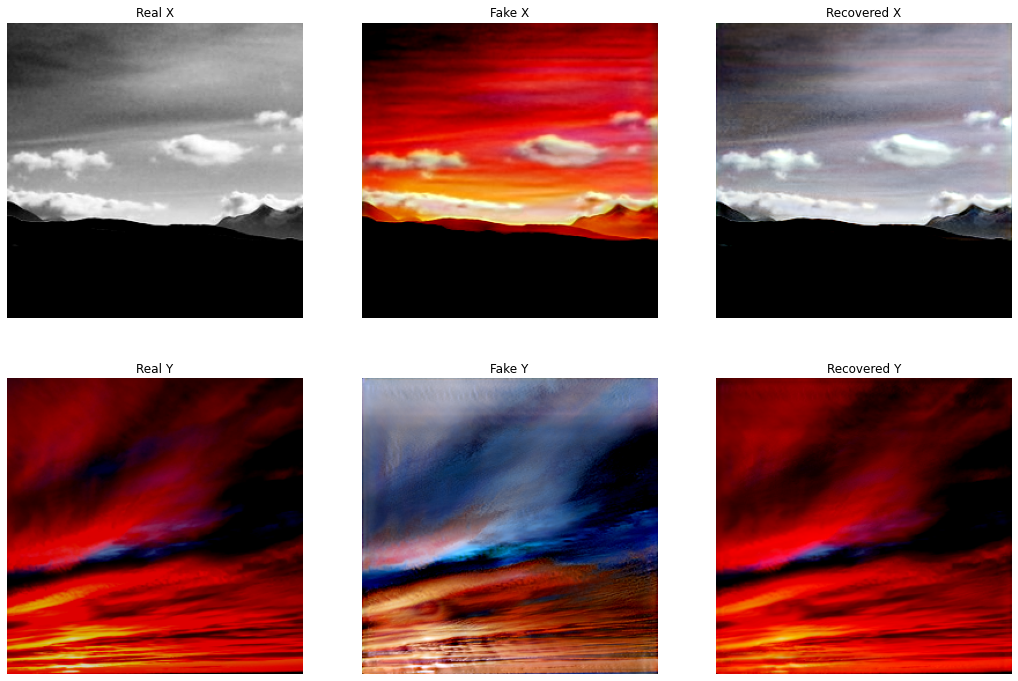

In [22]:
n = 4
show_images(real_image_x[n].detach(),
          fake_image_x[n].detach(),
          recovered_x[n].detach(),
          real_image_y[n].detach(),
          fake_image_y[n].detach(),
          recovered_y[n].detach())